# NDJSON Patient Data Analysis

This notebook demonstrates how to process FHIR Bulk Data (NDJSON) using `fhiry`. We will use sample data from the [SMART on FHIR sample datasets](https://github.com/smart-on-fhir/sample-bulk-fhir-datasets).

## 1. Setup and Installation

In [ ]:
%pip install fhiry seaborn matplotlib tqdm requests python-dotenv

In [4]:
%matplotlib inline
import fhiry.parallel as fp
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Set better visualization defaults
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
load_dotenv()

False

## 2. Load and Process Data

We will check for a local NDJSON folder. If not found, we'll download a small sample dataset.

In [5]:

# 10 Patients sample (Small)
# SAMPLE_DATA_URL = "https://github.com/smart-on-fhir/sample-bulk-fhir-datasets/archive/refs/heads/10-patients.zip"
# Unzip to ./sample_data and remove log.ngjson after extraction
LOCAL_DATA_DIR = "./sample_data"


# Process NDJSON files into a pandas DataFrame
df = fp.ndjson(LOCAL_DATA_DIR)

print(df.info())
print("Columns:", df.columns.tolist())
df.head()

Processing NDJSON files: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19143 entries, 0 to 19142
Columns: 126 entries, exportId to physicalType.coding.codes
dtypes: float64(11), object(115)
memory usage: 18.4+ MB
None
Columns: ['exportId', 'timestamp', 'eventId', 'eventDetail.exportUrl', 'eventDetail.transactionTime', 'eventDetail.totalOutputFileCount', 'eventDetail.totalDeletedFileCount', 'eventDetail.totalErrorFileCount', 'eventDetail.totalManifests', 'eventDetail.files', 'eventDetail.resources', 'eventDetail.bytes', 'eventDetail.duration', 'resourceType', 'id', 'extension', 'identifier', 'active', 'type', 'name', 'telecom', 'address', 'meta.profile', 'patientId', 'category', 'criticality', 'recordedDate', 'code.text', 'patient.reference', 'clinicalStatus.coding.codes', 'verificationStatus.coding.codes', 'code.coding.codes', 'reaction', 'gender', 'birthDate', 'deceasedDateTime', 'multipleBirthBoolean', 'communication', 'text.status', 'text.div', 'maritalStatus.text', 'maritalStatus.coding.codes', 'status

,exportId,timestamp,eventId,eventDetail.exportUrl,eventDetail.transactionTime,eventDetail.totalOutputFileCount,eventDetail.totalDeletedFileCount,eventDetail.totalErrorFileCount,eventDetail.totalManifests,eventDetail.files,...,address.postalCode,address.country,position.longitude,position.latitude,managingOrganization.identifier.system,managingOrganization.identifier.value,managingOrganization.display.display,description,mode,physicalType.coding.codes
0,export-10,2024-08-06T14:11:57.560606-04:00,kickoff,https://example.com/fhir/Group/sample-10/$export,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,export-10,2024-08-06T14:12:57.779320-04:00,status_complete,NaN,2024-08-06T18:12:57Z,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,export-10,2024-08-06T14:12:57.779320-04:00,manifest_complete,NaN,2024-08-06T18:12:57Z,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,export-10,2024-08-06T14:12:58.124336-04:00,export_complete,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Patient Demographics

Visualize the gender distribution of patients in the bulk export.

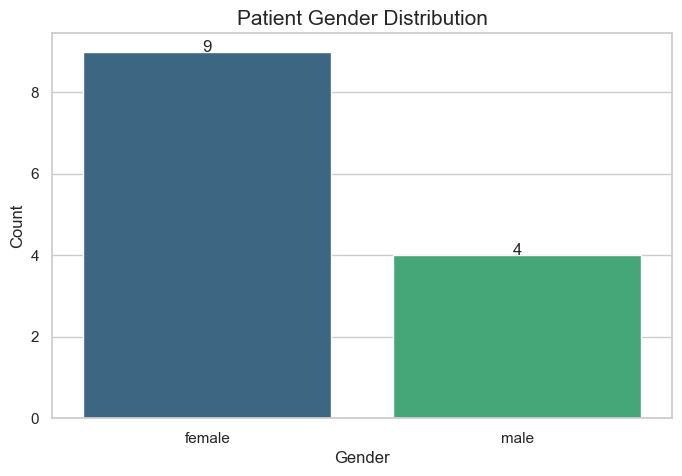

In [6]:
# fhiry usually strips 'resource.' prefix, but let's be robust
gender_col = next((c for c in df.columns if c == 'gender' or c == 'resource.gender'), None)

if gender_col:
    plt.figure(figsize=(8, 5))
    # If mixed resources, filter for Patient
    if 'resourceType' in df.columns:
        plot_df = df[df['resourceType'] == 'Patient']
    else:
        plot_df = df

    ax = sns.countplot(data=plot_df, x=gender_col, hue=gender_col, palette='viridis')
    plt.title('Patient Gender Distribution', fontsize=15)
    plt.xlabel('Gender')
    plt.ylabel('Count')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline')
    plt.show()
else:
    print("Gender column not found in dataset. Columns available:", df.columns.tolist())

## 4. Resource Type Distribution

Since NDJSON exports contain multiple resource types, let's look at the distribution of resources.

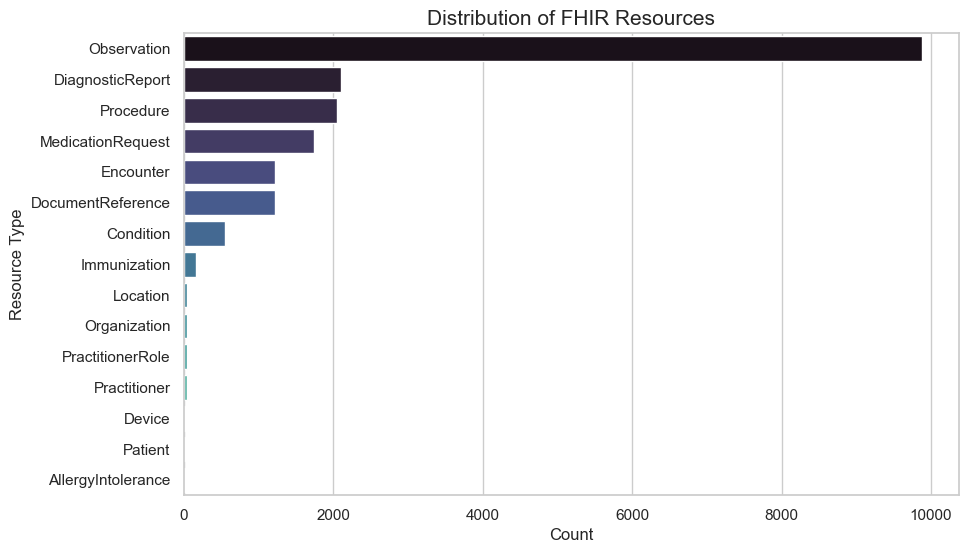

In [12]:
# Robust column finding for resourceType
type_col = next(
    (c for c in df.columns if c == "resourceType" or c == "resource.resourceType"), None
)

if type_col:
    plt.figure(figsize=(10, 6))
    resource_counts = df[type_col].value_counts()
    # Assign resource type to hue and set legend=False to avoid deprecation warning
    sns.barplot(
        x=resource_counts.values,
        y=resource_counts.index,
        hue=resource_counts.index,
        palette="mako",
        legend=False,
    )
    plt.title("Distribution of FHIR Resources", fontsize=15)
    plt.xlabel("Count")
    plt.ylabel("Resource Type")
    plt.show()
else:
    print("resourceType column not found.")